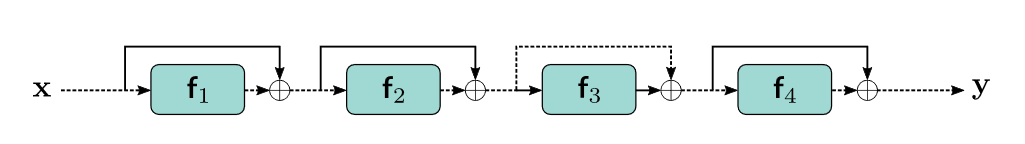

Files already downloaded and verified
Files already downloaded and verified
Epoch [1/25], Train Loss: 1.5464, Train Acc: 43.62%, Val Loss: 1.3702, Val Acc: 50.45%
Epoch [2/25], Train Loss: 1.1350, Train Acc: 59.56%, Val Loss: 1.1206, Val Acc: 60.49%
Epoch [3/25], Train Loss: 0.9453, Train Acc: 66.69%, Val Loss: 0.9163, Val Acc: 67.33%
Epoch [4/25], Train Loss: 0.8173, Train Acc: 71.43%, Val Loss: 0.9402, Val Acc: 67.20%
Epoch [5/25], Train Loss: 0.7223, Train Acc: 74.84%, Val Loss: 0.8539, Val Acc: 69.83%
Epoch [6/25], Train Loss: 0.6590, Train Acc: 77.07%, Val Loss: 0.7509, Val Acc: 73.70%
Epoch [7/25], Train Loss: 0.6119, Train Acc: 78.76%, Val Loss: 0.8179, Val Acc: 72.19%
Epoch [8/25], Train Loss: 0.5689, Train Acc: 80.24%, Val Loss: 0.7299, Val Acc: 74.92%
Epoch [9/25], Train Loss: 0.5322, Train Acc: 81.43%, Val Loss: 0.6317, Val Acc: 78.17%
Epoch [10/25], Train Loss: 0.4958, Train Acc: 82.72%, Val Loss: 0.6463, Val Acc: 78.31%
Epoch [11/25], Train Loss: 0.4712, Train Acc: 83.51%,

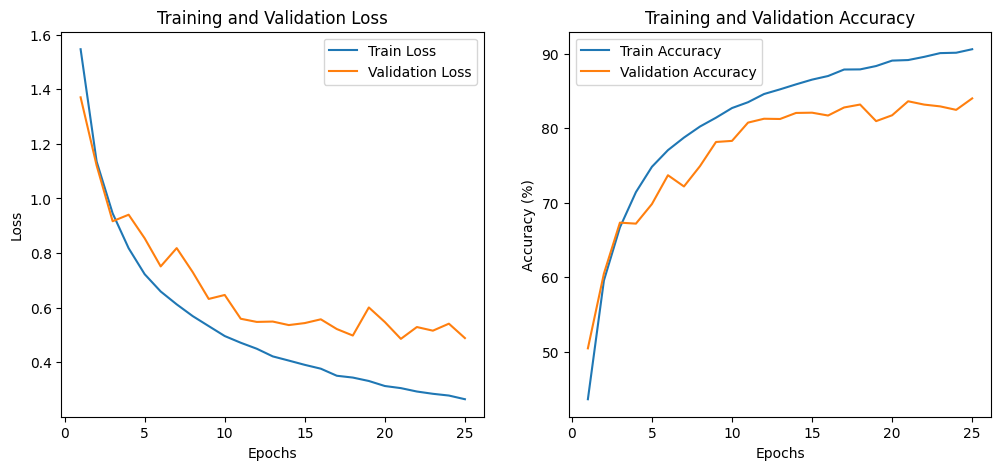

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import random_split, DataLoader

class ResidualBlock(nn.Module):
    def __init__(self, inchannel, outchannel, stride=1):
        super(ResidualBlock, self).__init__()
        self.left = nn.Sequential(
            nn.Conv2d(inchannel, outchannel, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(outchannel),
            nn.ReLU(inplace=True),
            nn.Conv2d(outchannel, outchannel, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(outchannel)
        )
        self.shortcut = nn.Sequential()
        if stride != 1 or inchannel != outchannel:
            self.shortcut = nn.Sequential(
                nn.Conv2d(inchannel, outchannel, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(outchannel)
            )

    def forward(self, x):
        out = self.left(x)
        out = out + self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, ResidualBlock, num_classes=10):
        super(ResNet, self).__init__()
        self.inchannel = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        self.layer1 = self.make_layer(ResidualBlock, 64, 2, stride=1)
        self.layer2 = self.make_layer(ResidualBlock, 128, 2, stride=2)
        self.layer3 = self.make_layer(ResidualBlock, 256, 2, stride=2)
        self.layer4 = self.make_layer(ResidualBlock, 512, 2, stride=2)
        self.fc = nn.Linear(512 * 1 * 1, num_classes)

    def make_layer(self, block, channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.inchannel, channels, stride))
            self.inchannel = channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, out.size()[2:])
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

def ResNet18():
    return ResNet(ResidualBlock)

transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

dataset = torchvision.datasets.CIFAR10(root='../data', train=True, download=True, transform=transform)
train_size = int(0.7 * len(dataset))
val_size = len(dataset) - train_size
trainset, valset = random_split(dataset, [train_size, val_size])

trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
valloader = DataLoader(valset, batch_size=128, shuffle=False, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='../data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = ResNet18().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

EPOCHS = 25
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(EPOCHS):
    net.train()
    running_loss, correct, total = 0.0, 0, 0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(trainloader)
    train_accuracy = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    net.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in valloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(valloader)
    val_accuracy = 100 * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch [{epoch+1}/{EPOCHS}], Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCHS + 1), train_losses, label='Train Loss')
plt.plot(range(1, EPOCHS + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(range(1, EPOCHS + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, EPOCHS + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.show()

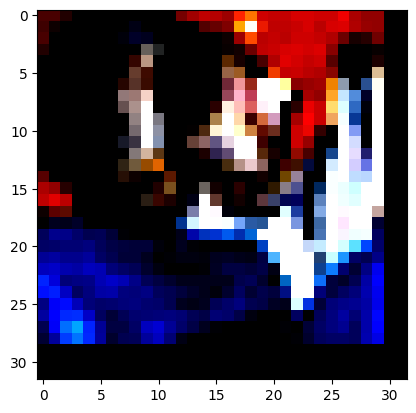

Label: cat


In [4]:
dataiter = iter(testloader)
images, labels = next(dataiter)

image = images[0].numpy().transpose((1, 2, 0))

plt.imshow(image)
plt.show()

print("Label:", testset.classes[labels[0]])

Predicted: cat


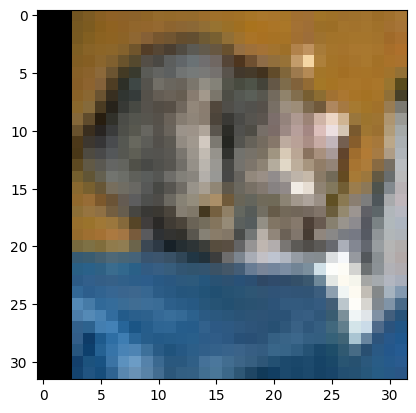

Label: cat


In [8]:
import torch
import numpy as np
dataiter = iter(testloader)
images, labels = next(dataiter)

image = images[0].unsqueeze(0).to(device)


with torch.no_grad():
    outputs = net(image)
    _, predicted = torch.max(outputs, 1)

print("Predicted:", testset.classes[predicted[0]])

image = images[0].cpu().numpy().transpose((1, 2, 0))
mean = [0.4914, 0.4822, 0.4465]
std = [0.2023, 0.1994, 0.2010]
image = std * image + mean
image = np.clip(image, 0, 1)

plt.imshow(image)
plt.show()


print("Label:", testset.classes[labels[0]])

In [ ]:
from PIL import Image

image_path = ''
image = Image.open(image_path)

image = transform(image)
image = image.unsqueeze(0)
image = image.to(device)

net.eval()

with torch.no_grad():
    output = net(image)

_, predicted = torch.max(output, 1)
